# scikit-learn: Classification with AdaBoost
 >__Created__:  October 8 2022 ASP 2022 South Africa, Harrison B. Prosper<br>
 > ATLAS Open Data<br>
 >__Updated__: March 19 2023 for CLASHEP 2023, San Esteban, Chile
 
 
Task: discriminate between Higgs boson events produced via vector boson fusion from events produced via gluon gluon fusion using the di-jet mass $m_{jj}$ (massjj) and the di-jet separation $|\Delta\eta_{jj}|$ (detajj) in pseudo-rapidity. This, of course, requires events with an least two jets.

In [1]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text, plot_tree

# standard measures of model performance
from sklearn.metrics import roc_curve, auc

#import joblib as jb
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

### Load ATLAS simulated HZZ4L data 

In [2]:
train = pd.read_csv('data/ATLAS_higgs_train.csv.gz')
test  = pd.read_csv('data/ATLAS_higgs_test.csv.gz')

print(len(train), len(test))

train[:10]

35000 10000


,Z1mass,Z2mass,mass4l,detajj,massjj,l1pdgid,l1pt,l1eta,l1phi,l2pdgid,...,l4phi,j1pt,j1eta,j1phi,j1E,j2pt,j2eta,j2phi,j2E,sample
0,146.606893,61.020177,125.711468,2.326696,108.181830,-13,51.951103,0.411997,2.619815,11,...,1.755059,39.439919,-1.503891,-1.140231,140.799629,34.825775,0.822805,-0.826908,47.541206,-1
1,114.353818,50.246461,126.316617,3.594605,308.374130,13,38.206276,-0.680229,-3.054557,-11,...,1.843560,57.332779,1.702152,-0.312091,308.979095,43.093277,-1.892453,2.740942,146.377747,1
2,247.983133,194.409336,124.762908,3.503917,616.358877,-11,76.114677,0.241155,3.125963,13,...,-3.062371,129.521744,2.459066,-0.301460,908.144211,90.466331,-1.044851,0.759266,145.233810,1
3,87.222797,21.669120,119.856044,0.225940,104.417114,13,74.349472,-1.324150,0.574192,-13,...,0.419230,149.973892,1.581369,-2.828373,437.785374,27.767351,1.355429,1.637750,57.644779,1
4,90.105345,21.121660,122.598368,2.141461,89.844592,11,59.942581,2.044135,0.088590,-11,...,0.168826,33.994389,-1.681468,0.292372,119.326447,22.235022,0.459994,-2.965300,24.800377,1
5,40.232980,34.045697,122.950267,0.588304,32.530848,-11,71.131760,-0.318877,-2.737749,11,...,-1.451241,71.667618,0.896478,0.759973,182.116890,34.144382,1.484781,0.860451,79.365562,1
6,59.752522,43.209175,127.001766,0.681153,35.833345,-11,60.327972,1.666291,1.070680,11,...,-0.117334,59.581280,1.332498,-1.139357,215.720375,24.622829,2.013651,-1.418474,94.054298,-1
7,202.490174,27.437492,122.715279,0.365844,149.575229,11,99.679100,-0.979891,0.537877,-11,...,-1.291118,197.055466,2.098770,-2.970273,903.742332,30.011684,1.732926,-0.558310,87.787560,-1
8,89.749094,9.677819,125.375388,0.056711,26.406022,11,56.226902,-0.772322,0.871658,-11,...,1.985418,24.557268,0.900926,-0.443676,65.457382,21.607994,0.844214,-1.601048,30.070992,-1
9,128.950745,24.308430,121.222698,2.763397,302.773899,11,71.661194,0.177808,-1.148681,11,...,0.594547,99.091858,2.014122,2.309782,446.685081,53.070251,-0.749275,-0.108870,68.704643,1


In [3]:
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'

XBINS =   5
XMIN  =   0
XMAX  =   5
XSTEP =   1

YBINS =   5
YMIN  =   0
YMAX  =1000
YSTEP = 200

inputs  = [XNAME, YNAME]
classes = ['GGF', 'VBF']

train_x = train[inputs]
train_y = train['sample']

test_x  = test[inputs]
test_y  = test['sample']

train_x[:5]

,detajj,massjj
0,2.326696,108.181830
1,3.594605,308.374130
2,3.503917,616.358877
3,0.225940,104.417114
4,2.141461,89.844592


### Approximate $p(y = 1| x)$ by histogramming

__Note__:
    
  * $x = (m_{jj}, |\Delta\eta_{jj}|)$
  * $y = 1$ for VBF events, $y = -1$ for ggf events

In [4]:
# split training data into VBF and ggF events

VBF = train['sample'] > 0
sig = train[VBF]

GGF = train['sample'] < 0
bkg = train[GGF]

s, xedges, yedges = np.histogram2d(sig[XNAME], sig[YNAME], 
                                   bins=(XBINS, YBINS), 
                                   range=((XMIN, XMAX), (YMIN, YMAX)))

b, xedges, yedges = np.histogram2d(bkg[XNAME], bkg[YNAME], 
                                   bins=(XBINS, YBINS), 
                                   range=((XMIN, XMAX), (YMIN, YMAX)))

# get bin centers. we need a meshgrid to plot approximated probability
x = (xedges[:-1]+xedges[1:])/2
y = (yedges[:-1]+yedges[1:])/2
x, y = np.meshgrid(x, y)

# WARNING: must transpose z so that x, y, and z have the
# same shape. Also protect against s + b == 0
d = np.where(s + b <= 0, 1e10, s + b)

# approximate z = p(y=1|data) and cache x, y, z in the 3-tuple H
z = (s / d).T
H = (x, y, z)

# choose a subset of test data to plot
K = 8000
t = test[:K]

VBF = t['sample'] > 0
sig = t[VBF]

GGF = t['sample'] < 0
bkg = t[GGF]

print(len(sig), len(bkg), len(sig)+len(bkg))

3983 4017 8000


### Plot contours of $p(y = 1| x)$, where $x = (m_{jj}, |\Delta\eta_{jj}|)$

histogram(a, bins=10, range=None, normed=None, weights=None, density=None)

In [5]:
def plot_data(sig, bkg, h=None,
              xname=XNAME, yname=YNAME, 
              xlabel=XLABEL, ylabel=YLABEL,
              xmin=XMIN, xmax=XMAX, xstep=XSTEP,
              ymin=YMIN, ymax=YMAX, ystep=YSTEP, 
              filename='hzz4l_sig_vs_bkg.png',
              fgsize=(5, 5), 
              alpha=0.2,
              contour_colors='rainbow_r',
              bdt_colors='rainbow_r',
              ftsize=FONTSIZE, 
              bdt=None):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    # annotate axes
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    
    ax.scatter(sig[xname], sig[yname], marker='o',
                s=20, c='blue', alpha=alpha, label='VBF')
    ax.legend(loc='upper left') # activate legend
    
    ax.scatter(bkg[xname], bkg[yname], marker='*',
                s=10, c='red',  alpha=alpha, label='ggf')
    
    # optional add BDT bins
    if bdt:
        bdt.plot2D(itree, ax, 
                   colormap=bdt_colors, 
                   alpha=alpha)
    else:
        ax.grid()
        
    if h:
        x, y, z = h
        mylevels = np.arange(0.1, 1, 0.1) 
        cs = ax.contour(x, y, z, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               cmap=contour_colors)
    
        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%3.1f', 
              colors='black')
    
    ax.legend(loc='upper left') # activate legend
    
    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

hzz4l_detajj_massjj.png


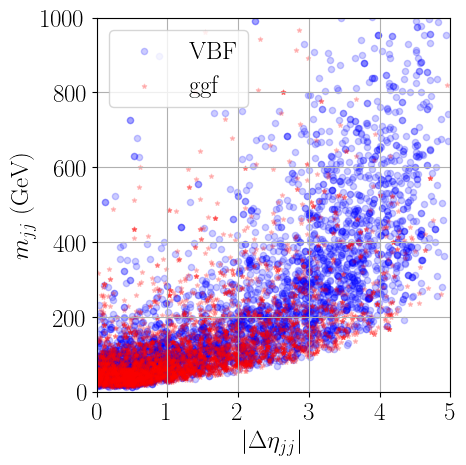

hzz4l_detajj_massjj_with_contours.png


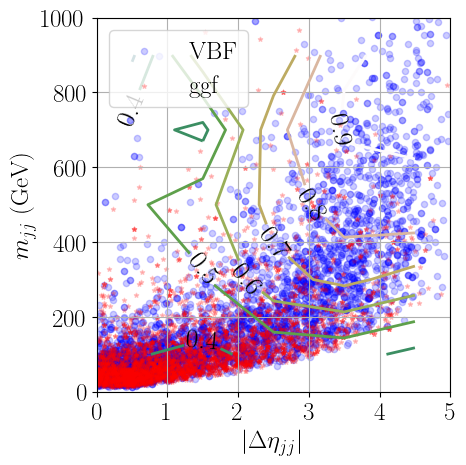

In [6]:
plot_data(sig, bkg, 
          filename='hzz4l_%s_%s.png' % (XNAME, YNAME),
          contour_colors='gist_earth')

plot_data(sig, bkg, H,
          filename='hzz4l_%s_%s_with_contours.png' % (XNAME, YNAME),
          contour_colors='gist_earth')

### Train boosted decision tree classifier

In [9]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6),
                         algorithm="SAMME", 
                         n_estimators=100)

print("Training...")
bdt.fit(train_x, train_y)

print("Training set score: %10.3f" % bdt.score(train_x, train_y))      
print("Test set score:     %10.3f" % bdt.score(test_x,  test_y))

Training...
Training set score:      0.657
Test set score:          0.627


### Load BDT wrapper class 

This Python class was adapted from one developed for TMVA many years ago.

For each leaf:
  * bweight: background fraction relative to sample size
  * sweight: signal fraction relative to sample size
  * value:   -1 or +1 for original AdaBoost algorithm

Welcome to JupyROOT 6.28/00

tree number 0	weight =  6.081e-01
   ROOT      massjj     214.20
  -- LEFT      massjj      95.48
  ---- LEFT      detajj       0.74
  ------ LEFT      massjj      59.32
  -------- LEFT      massjj      27.07
  ---------- LEFT      massjj      16.25
  ------------ LEFT  BKG   2.83e-03   7.70e-04      -1.00
  ------------ RIGHT BKG   2.63e-02   1.40e-02      -1.00
  ---------- RIGHT     detajj       0.73
  ------------ LEFT  BKG   8.21e-02   5.45e-02      -1.00
  ------------ RIGHT SIG   6.90e-04   9.70e-04       1.00
  -------- RIGHT     massjj      69.30
  ---------- LEFT      massjj      66.68
  ------------ LEFT  BKG   1.02e-02   9.09e-03      -1.00
  ------------ RIGHT BKG   5.03e-03   2.54e-03      -1.00
  ---------- RIGHT     detajj       0.00
  ------------ LEFT  BKG   2.90e-04   3.00e-05      -1.00
  ------------ RIGHT BKG   2.29e-02   2.16e-02      -1.00
  ------ RIGHT     detajj       1.42
  -------- LEFT      massjj      62.13
  ---------- LEFT  

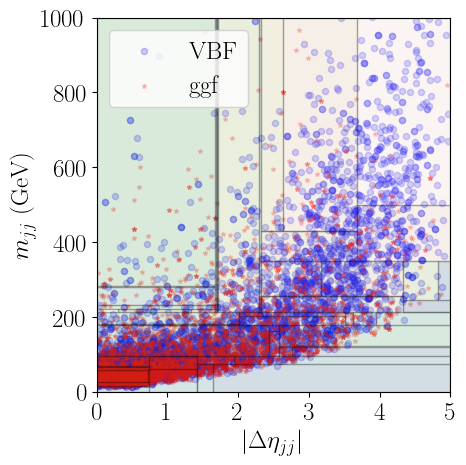

In [10]:
import bdtutil as bd
import ROOT

bdtree = bd.BDT(bdt)

itree = 0
bdtree.printTree(itree)

plot_data(sig, bkg,
          fgsize=(5, 5),
          filename='hzz4l_%s_%s_tree0.png' % (XNAME, YNAME), 
          bdt=bdtree, 
          bdt_colors='gist_earth')

In [12]:
def plot_a_tree(itree, bdt, feature_names, class_names, 
                filename='hzz4l_tree.png',
                fgsize=(5, 5),
                ftsize=FONTSIZE):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    artists = plot_tree(bdt.estimators_[itree], 
                        feature_names=feature_names, 
                        class_names=class_names, 
                        ax=ax,
                        proportion=True, filled=True)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()
    return artists

In [13]:
#artists = plot_a_tree(0, bdt, feature_names=inputs, class_names=classes)

In [14]:
def plot_trees(bdt, 
               xname=XNAME, yname=YNAME, 
               xlabel=XLABEL, ylabel=YLABEL,
               xmin=XMIN, xmax=XMAX, xstep=XSTEP,
               ymin=YMIN, ymax=YMAX, ystep=YSTEP, 
               filename='hzz4l_trees.png',
               fgsize=(8, 5), 
               alpha=0.2, colormap='gist_earth',
               ftsize=FONTSIZE):
    
    # make room for 6 sub-plots
    n_rows = 2
    n_cols = 3
    fig, axs = plt.subplots(nrows=n_rows, 
                            ncols=n_cols, 
                            figsize=fgsize)
    
    kk =-1
    for ii, ax in enumerate(axs.flatten()):
        jj = ii % n_cols
        if jj == 0:
            kk += 1
            
        # annotate axes
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        if jj == 0:
            ax.set_ylabel(ylabel, fontsize=ftsize)
            ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
            
        if kk+1 == n_rows:
            ax.set_xlabel(xlabel, fontsize=ftsize)
            ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
        bdt.plot2D(ii, ax, 
                   colormap=colormap, 
                   alpha=alpha)
    
    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

hzz4l_trees.png


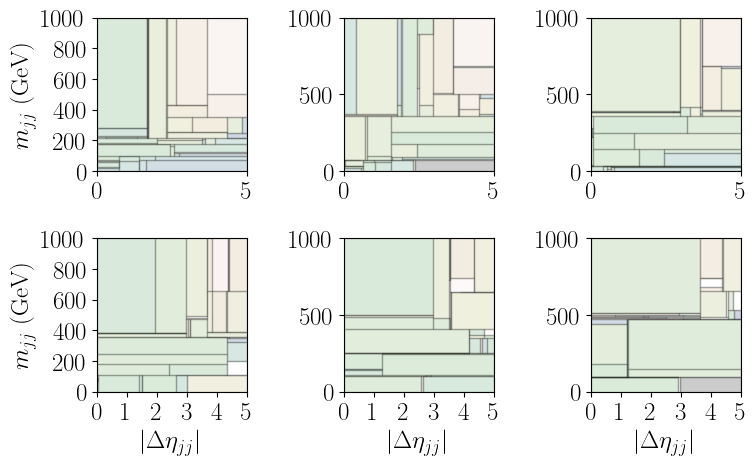

In [15]:
plot_trees(bdtree, colormap='gist_earth')

### Compare calculations between bdtree and (scikit-learn) bdt


In [16]:
x   = test_x[:10]
print(x)
print()

print('using scikit-learn definition of decision function')
print('%10s %10s\t%10s %10s' % \
      ('bdtree', 'bdt', 'bdtree(p)', 'bdt(p)'))

Y1  = bdtree.decision_function(x, like_scikit_learn=True)
P1  = bdtree.predict_proba(x, like_scikit_learn=True)

Y2  = bdt.decision_function(x)
print(Y2.shape)
P2  = bdt.predict_proba(x).T[-1]

for y1, y2, p1, p2 in zip(Y1, Y2, P1, P2):
    print('%10.5f %10.5f\t%10.5f %10.5f' % \
          (y1, y2, p1, p2))
print()
print('using correct definition of decision function')
print('%10s %10s' % ('bdtree', 'bdtree(p)'))

x   = test_x[:10]
Y1  = bdtree.decision_function(x)
P1  = bdtree.predict_proba(x)

for y1, p1 in zip(Y1, P1):
    print('%10.5f %10.5f' % (y1, p1))

     detajj      massjj
0  1.082408  113.311777
1  1.641027  179.830829
2  0.338112   55.178857
3  0.261754   59.444241
4  2.383809  147.081781
5  3.583731  390.087321
6  3.305386  275.578132
7  1.320555  124.313348
8  3.633506  297.291068
9  0.121479   21.734252

using scikit-learn definition of decision function
    bdtree        bdt	 bdtree(p)     bdt(p)
(10,)
  -0.01273   -0.01273	   0.49682    0.49682
   0.12255    0.12255	   0.53060    0.53060
  -0.08451   -0.08451	   0.47888    0.47888
  -0.10751   -0.10751	   0.47315    0.47315
   0.01324    0.01324	   0.50331    0.50331
   0.39514    0.39514	   0.59752    0.59752
   0.33354    0.33354	   0.58262    0.58262
   0.06019    0.06019	   0.51504    0.51504
   0.27734    0.27734	   0.56890    0.56890
  -0.13811   -0.13811	   0.46553    0.46553

using correct definition of decision function
    bdtree  bdtree(p)
  -0.05060    0.48735
   0.48729    0.61947
  -0.33605    0.41677
  -0.42749    0.39473
   0.05265    0.51316
   1.57116    0

### Plot contours of constant signal probability

Even though the __AdaBoost__ algorithm is rather cryptic, it is equivalent to an algorithm that minimizes the average exponential loss, $L = \exp(-w t f / 2)$, with $w = 1$ and where the targets at $t = -1$ for ggF and $t= +1$ for VBF. Minimizing the average loss (for an infinite amount of data) requires solving

\begin{align}
    \int \frac{\partial L}{\partial f} \, p(t | x) \, dt & = 0,
\end{align}

to determine the mathematical expression approximated by the model $f(x, \omega)$ with free parameters $\omega$. When the above is solved for the exponential loss one concludes that the best fit model, $\hat{f}$ (determined with a *finite* data sample), approximates the optimal model 

\begin{align}
    f^* & =  \log \left[\frac{p(x | t = +1)}{p(x | t = -1)} \epsilon\right] ,
\end{align}

which can be rearranged as

\begin{align}
    p(t = +1 | x) & = \frac{1}{1 + \exp(-f^*)},\\
    & = \frac{p(x | t = +1) \, \epsilon}{p(x | t = +1) \, \epsilon + p(x | t = -1) } ,
\end{align}

where $\epsilon = \pi(t = +1) \, / \, \pi(t = -1)$ is the prior signal to background ratio, which in this example is 1.

In [17]:
def plot_contours(bdtree, sig, bkg, h=None, 
                  add_bdt_contours=False,
                  colormap='gist_earth_r',
                  numTrees=-1, 
                  xname=XNAME, yname=YNAME, 
                  xlabel=XLABEL, ylabel=YLABEL,
                  xmin=XMIN, xmax=XMAX, xstep=XSTEP,
                  ymin=YMIN, ymax=YMAX, ystep=YSTEP,
                  fgsize=(6, 5), 
                  alpha=0.5,
                  ftsize=FONTSIZE, 
                  filename='hzz4l_forest.png'):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # annotate axes
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    
    ax.scatter(sig[xname], sig[yname], marker='o',
                s=20, c='blue', alpha=alpha, label='VBF')
    ax.legend(loc='upper left') # activate legend
    
    ax.scatter(bkg[xname], bkg[yname], marker='*',
                s=10, c='red',  alpha=alpha, label='ggF')
    ax.legend(loc='upper left') # activate legend
    
    # superimpose a BDT contour plot
    # 1. first create a meshgrid
    # 2. compute network output at all mesh points
    npoints= 100
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    xx     = np.arange(xmin, xmax, xdelta)
    yy     = np.arange(ymin, ymax, ydelta)
    X, Y   = np.meshgrid(xx, yy)
    
    # compute model probability at every grid point
    # then reshape to an (npoints x npoints) array
    df = pd.DataFrame({xname: X.flatten(), yname: Y.flatten()})
    
    Z  = bdtree.predict_proba(df, numTrees).reshape([npoints, npoints])

    plt.imshow(Z, origin='lower', aspect='auto', 
               extent=(xmin, xmax, ymin, ymax), 
               cmap=colormap)
    plt.colorbar()
    
    mylevels = np.arange(0.1, 1, 0.1) 
    
    if add_bdt_contours:
        npoints= 10
        xdelta = float(xmax-xmin)/npoints
        ydelta = float(ymax-ymin)/npoints
        xx     = np.arange(xmin, xmax, xdelta)
        yy     = np.arange(ymin, ymax, ydelta)
        X2, Y2 = np.meshgrid(xx, yy)
        df     = pd.DataFrame({xname: X2.flatten(), yname: Y2.flatten()})
        
        Z2  = bdtree.predict_proba(df, numTrees,
                                   like_scikit_learn=False).reshape([npoints, 
                                                          npoints])

        cs = ax.contour(X2, Y2, Z2, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               linestyles='dashed',
               cmap='rainbow_r')
    
    if h:
        x, y, z = h
        cs = ax.contour(x, y, z, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
                    cmap='gist_earth_r')
    
        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%3.1f', 
              colors='black')

    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

One sees that the boosted decision tree agrees with the probability contours approximated by histogramming.

hzz4l_forest.png


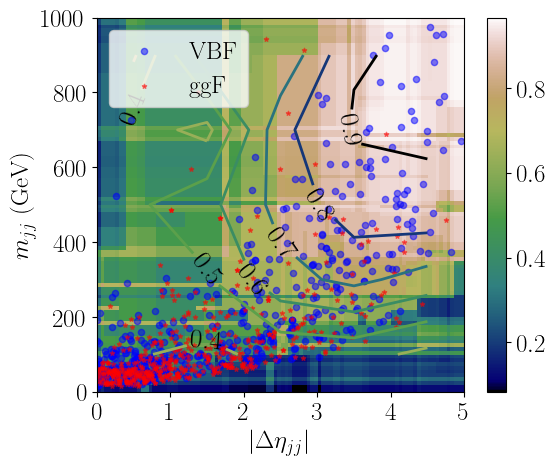

In [18]:
K = 500
plot_contours(bdtree, sig[:K], bkg[:K], h=H,
              add_bdt_contours=False,
              colormap='gist_earth')